In [3]:
import numpy as np
import matplotlib.pyplot as plt
from galton_utils import create_combined_plot, simulate_multiple_beads
%matplotlib inline

# Galton Board Simulation Utilities Documentation

This module contains utilities for simulating and visualizing a Galton Board with memory effect on a rocking ship.

## Simulation Functions

### `simulate_single_bead(alpha, s, n_rows=31)`
Simulates the path of a single bead through the Galton board.
- **Parameters:**
  - `alpha`: Memory effect parameter [0, 0.5]
  - `s`: Ship tilt parameter [-0.25, 0.25]
  - `n_rows`: Number of rows in the board (default: 31)
- **Returns:** Final position of the bead (0 to n_rows)

### `simulate_multiple_beads(n_beads, alpha, s, n_rows=31)`
Simulates multiple beads through the Galton board.
- **Parameters:**
  - `n_beads`: Number of beads to simulate
  - `alpha`: Memory effect parameter [0, 0.5]
  - `s`: Ship tilt parameter [-0.25, 0.25]
  - `n_rows`: Number of rows in the board (default: 31)
- **Returns:** Array with the count of beads in each final position

## Visualization Functions

### `plot_galton_board(ax)`
Creates a stylized visualization of the Galton board structure.
- **Parameters:**
  - `ax`: Matplotlib axes object to plot on

### `plot_bead_distribution(positions, counts, ax)`
Plots the distribution of beads as a bar chart.
- **Parameters:**
  - `positions`: Array of x-positions (typically 0 to 31)
  - `counts`: Array of bead counts at each position
  - `ax`: Matplotlib axes object to plot on

### `create_combined_plot(counts, title=None)`
Creates a combined visualization with both the Galton board and bead distribution.
- **Parameters:**
  - `counts`: Array of bead counts at each position
  - `title`: Optional title for the plot
- **Returns:** Tuple of (figure, (ax1, ax2))

### `plot_distribution_only(counts, title=None)`
Creates a single plot showing just the bead distribution.
- **Parameters:**
  - `counts`: Array of bead counts at each position
  - `title`: Optional title for the plot
- **Returns:** Tuple of (figure, ax)

## Usage Example:
```python
# Run simulation
results = simulate_multiple_beads(n_beads=1000, alpha=0.2, s=0.1)

# Create visualization
fig, axes = create_combined_plot(
    results, 
    'Galton Board Simulation'
)
plt.show()

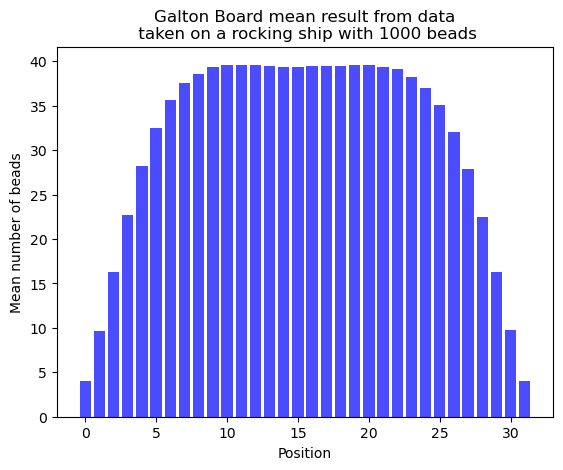

In [4]:
data = np.load('board_data_.npy')

#plot mean of rows in bar chart
mean_data = np.mean(data, axis=0)
plt.bar(np.arange(len(mean_data)), mean_data, color = 'blue', alpha = 0.7)
plt.xlabel('Position')
plt.ylabel('Mean number of beads')
plt.title('Galton Board mean result from data\n taken on a rocking ship with 1000 beads')
plt.show()

(<Figure size 1200x400 with 1 Axes>,
 <Axes: title={'center': 'First experiment'}, xlabel='Position', ylabel='Number of beads'>)

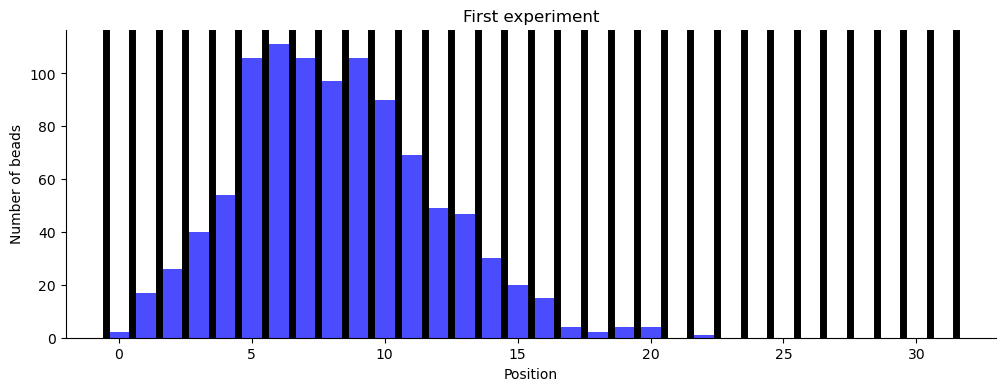

In [5]:
from galton_utils import plot_distribution_only

# plot single experiment
counts = data[0]

plot_distribution_only(counts, 'First experiment')




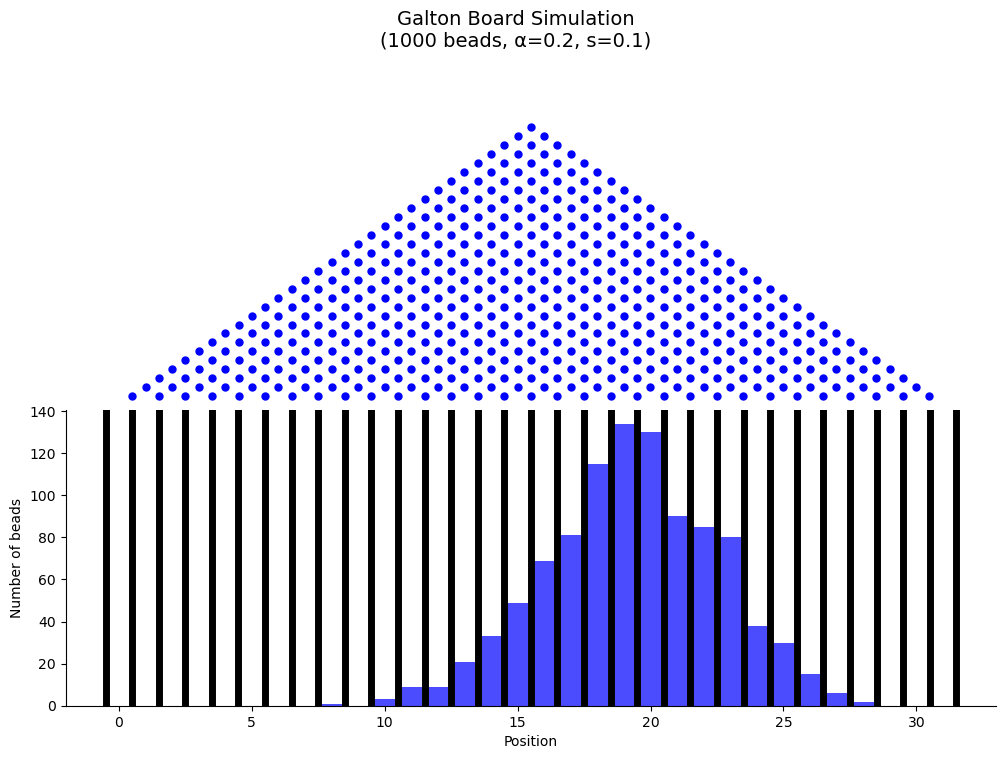

Total beads: 1000
Mean position: 19.28


In [6]:
# Test parameters
n_beads = 1000
alpha_test = 0.2
s_test = 0.1

# Run simulation
results = simulate_multiple_beads(n_beads, alpha_test, s_test)

# Create combined plot
fig, axes = create_combined_plot(
    results, 
    f'Galton Board Simulation\n({n_beads} beads, α={alpha_test}, s={s_test})'
)
plt.show()

# Print some statistics
print(f"Total beads: {np.sum(results)}")
print(f"Mean position: {np.average(range(len(results)), weights=results):.2f}")

In [7]:
import numpy as np
from galton_utils import simulate_multiple_beads

def calculate_summary_statistics(distribution):
    """
    Calculate summary statistics for a bead distribution
    Returns: (mean position, standard deviation)
    """
    positions = np.arange(len(distribution))
    mean = np.average(positions, weights=distribution)
    # Calculate weighted standard deviation
    variance = np.average((positions - mean)**2, weights=distribution)
    std = np.sqrt(variance)
    return mean, std


No memory, No tilt:
Means: 15.51 ± 0.06
Stds: 2.76 ± 0.05

Strong memory, No tilt:
Means: 15.52 ± 0.20
Stds: 4.21 ± 0.07

No memory, Right tilt:
Means: 21.68 ± 0.05
Stds: 2.55 ± 0.01

Strong memory, Right tilt:
Means: 31.00 ± 0.00
Stds: 0.00 ± 0.00


### Solve task 2 by using abc rejection algo

Running 1 iterations per experiment


Running ABC: 100%|██████████| 10000/10000 [02:09<00:00, 77.11it/s]



Total accepted samples: 8
Average acceptance rate: 0.1%


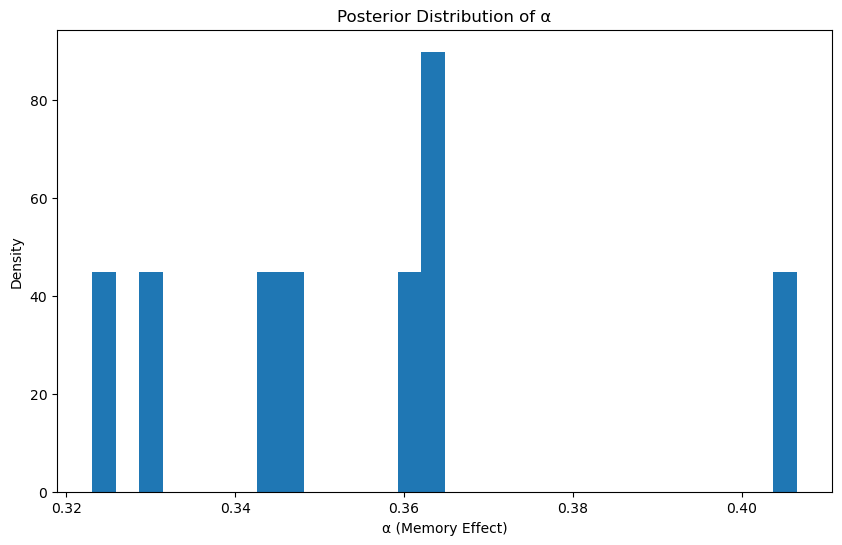

Estimated α (mean): 0.355
95% Credible Interval: [0.324, 0.399]
Number of accepted samples: 8
Acceptance rate: 0.8%


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from galton_utils import simulate_multiple_beads
from multiprocessing import Pool
from tqdm import tqdm

def calculate_summary_statistics(distribution):
    """Calculate summary statistics for a single bead distribution."""
    positions = np.arange(len(distribution))
    mean = np.average(positions, weights=distribution)
    variance = np.average((positions - mean)**2, weights=distribution)
    std = np.sqrt(variance)
    return (mean, std)  # Explicitly return as tuple

def gaussian_kernel(x, h):
    """Compute Gaussian kernel."""
    return np.exp(-0.5 * (x/h)**2)

def compute_distance(stats1, stats2):
    """Compute distances between two sets of summary statistics."""
    mean1, std1 = stats1
    mean2, std2 = stats2
    mean_dist = np.abs(mean1 - mean2)
    std_dist = np.abs(std1 - std2)
    return mean_dist, std_dist

def simulate_and_evaluate(args):
    """Function to run one simulation and evaluation.
    
    Args:
        args: tuple containing (observed_stats, h, iterations)
    """
    observed_stats, h, iterations = args
    
    accepted_alphas = []
    for _ in range(iterations):
        # Generate proposals
        alpha_proposal = np.random.uniform(0, 0.5)
        s_proposal = np.random.uniform(-0.25, 0.25)
        
        # Simulate
        simulated_data = simulate_multiple_beads(1000, alpha_proposal, s_proposal)
        simulated_stats = calculate_summary_statistics(simulated_data)
        
        # Compare
        mean_dist, std_dist = compute_distance(observed_stats, simulated_stats)
        kernel_value = gaussian_kernel(mean_dist, h) * gaussian_kernel(std_dist, h)
        
        # Add to accepted if accepted
        if np.random.random() < kernel_value:
            accepted_alphas.append(alpha_proposal)
            
    return accepted_alphas

def abc_rejection_parallel(data, n_iterations=1000, h=0.1, n_cores=None):
    """Parallel ABC rejection algorithm."""
    # Calculate iterations per experiment
    iterations_per_experiment = max(1, n_iterations // len(data))
    print(f"Running {iterations_per_experiment} iterations per experiment")
    
    all_accepted_alphas = []
    
    # Create list of arguments for parallel processing
    args_list = []
    for experiment in data:
        observed_stats = calculate_summary_statistics(experiment)
        args_list.append((observed_stats, h, iterations_per_experiment))
    
    # Run parallel simulations with progress bar
    with Pool(processes=n_cores) as pool:
        results = list(tqdm(
            pool.imap(simulate_and_evaluate, args_list),
            total=len(data),
            desc="Running ABC"
        ))
    
    # Combine all accepted alphas
    for accepted_alphas in results:
        all_accepted_alphas.extend(accepted_alphas)
    
    print(f"\nTotal accepted samples: {len(all_accepted_alphas)}")
    print(f"Average acceptance rate: {len(all_accepted_alphas)/(len(data)*iterations_per_experiment):.1%}")
    
    return all_accepted_alphas

# Load and prepare data
data = np.load('board_data_.npy')

# Run parallel ABC algorithm
alphas = abc_rejection_parallel(data, n_iterations=1000)

# Visualize results
plt.figure(figsize=(10, 6))
plt.hist(alphas, bins=30, density=True)
plt.xlabel('α (Memory Effect)')
plt.ylabel('Density')
plt.title('Posterior Distribution of α')
plt.show()

# Print statistics
print(f"Estimated α (mean): {np.mean(alphas):.3f}")
print(f"95% Credible Interval: [{np.percentile(alphas, 2.5):.3f}, {np.percentile(alphas, 97.5):.3f}]")
print(f"Number of accepted samples: {len(alphas)}")
print(f"Acceptance rate: {len(alphas)/1000:.1%}")

In [51]:
import torch
import torch.nn as nn
import numpy as np
from galton_utils import simulate_multiple_beads

def generate_training_data(n_samples=1000, n_beads=1000):
    """
    Generate training data by simulating Galton board experiments
    
    Args:
        n_samples: Number of different (alpha, s) combinations to generate
        n_beads: Number of beads per experiment
    Returns:
        X: Tensor of bead distributions (n_samples x 32)
        y: Tensor of parameters [alpha, s] (n_samples x 2)
    """
    X = []  # Store distributions
    y = []  # Store parameters (alpha, s)
    
    for _ in range(n_samples):
        # Generate random parameters
        alpha = np.random.uniform(0, 0.5)      # Memory effect
        s = np.random.uniform(-0.25, 0.25)     # Ship tilt
        
        # Run simulation
        distribution = simulate_multiple_beads(n_beads, alpha, s)
        
        X.append(distribution)
        y.append([alpha, s])
    
    return torch.FloatTensor(X), torch.FloatTensor(y)

class GaltonPredictor(nn.Module):
    """
    Neural network to predict alpha and s parameters from bead distribution
    Input: Distribution of beads (32 positions)
    Output: Predicted alpha (0 to 0.5) and s (-0.25 to 0.25)
    """
    def __init__(self):
        super(GaltonPredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(32, 64),    # First hidden layer
            nn.ReLU(),
            nn.Linear(64, 32),    # Second hidden layer
            nn.ReLU(),
            nn.Linear(32, 2)      # Output layer (alpha, s)
        )
        
        # Activation functions for output scaling
        self.alpha_activation = nn.Sigmoid()  # For alpha (scales to 0-1)
        self.s_activation = nn.Tanh()        # For s (scales to -1 to 1)
        
    def forward(self, x):
        x = self.network(x)
        
        # Scale outputs to correct ranges
        alpha = 0.5 * self.alpha_activation(x[:, 0])    # Scale to [0, 0.5]
        s = 0.25 * self.s_activation(x[:, 1])          # Scale to [-0.25, 0.25]
        
        return torch.stack([alpha, s], dim=1)

# Training setup
def train_model(n_epochs=100, batch_size=32, learning_rate=0.001):
    """
    Train the Galton board parameter predictor
    
    Args:
        n_epochs: Number of training epochs
        batch_size: Size of mini-batches
        learning_rate: Learning rate for optimizer
    """
    # Generate training data
    X, y = generate_training_data()
    
    # Create model and optimizer
    model = GaltonPredictor()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Training loop
    for epoch in range(n_epochs):
        # Shuffle data
        indices = torch.randperm(len(X))
        X = X[indices]
        y = y[indices]
        
        total_loss = 0
        
        # Mini-batch training
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size]
            batch_y = y[i:i+batch_size]
            
            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / (len(X) // batch_size)
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}')
    
    return model

# Function to evaluate model predictions
def evaluate_model(model, n_test=100):
    """
    Evaluate model performance on test data
    
    Args:
        model: Trained GaltonPredictor model
        n_test: Number of test cases
    """
    model.eval()
    X_test, y_test = generate_training_data(n_samples=n_test)
    
    with torch.no_grad():
        predictions = model(X_test)
        
        # Compute errors
        alpha_errors = predictions[:, 0] - y_test[:, 0]
        s_errors = predictions[:, 1] - y_test[:, 1]
        
        print(f"Alpha - Mean Error: {alpha_errors.mean():.4f}, Std: {alpha_errors.std():.4f}")
        print(f"s - Mean Error: {s_errors.mean():.4f}, Std: {s_errors.std():.4f}")

# Run training and evaluation
if __name__ == "__main__":
    model = train_model()
    evaluate_model(model)

/tmp/ipykernel_56224/914991481.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788959220/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(X), torch.FloatTensor(y)


Epoch [10/100], Loss: 0.0009
Epoch [20/100], Loss: 0.0006
Epoch [30/100], Loss: 0.0004
Epoch [40/100], Loss: 0.0004
Epoch [50/100], Loss: 0.0006
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0003
Alpha - Mean Error: -0.0000, Std: 0.0303
s - Mean Error: -0.0019, Std: 0.0092


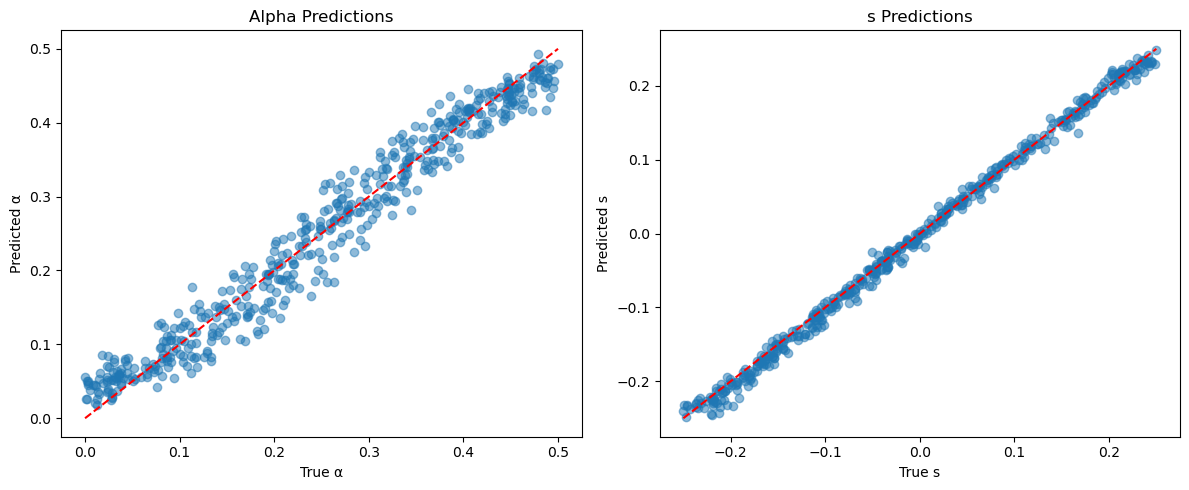

In [52]:
import matplotlib.pyplot as plt

def visualize_predictions(model, n_test=500):
    """
    Create scatter plots comparing predicted vs actual values
    for both alpha and s parameters
    """
    # Generate test data
    model.eval()
    X_test, y_test = generate_training_data(n_samples=n_test)
    
    with torch.no_grad():
        predictions = model(X_test)
        
        # Convert to numpy for plotting
        pred_alpha = predictions[:, 0].numpy()
        true_alpha = y_test[:, 0].numpy()
        pred_s = predictions[:, 1].numpy()
        true_s = y_test[:, 1].numpy()
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot alpha predictions
        ax1.scatter(true_alpha, pred_alpha, alpha=0.5)
        ax1.plot([0, 0.5], [0, 0.5], 'r--')  # Perfect prediction line
        ax1.set_xlabel('True α')
        ax1.set_ylabel('Predicted α')
        ax1.set_title('Alpha Predictions')
        
        # Plot s predictions
        ax2.scatter(true_s, pred_s, alpha=0.5)
        ax2.plot([-0.25, 0.25], [-0.25, 0.25], 'r--')  # Perfect prediction line
        ax2.set_xlabel('True s')
        ax2.set_ylabel('Predicted s')
        ax2.set_title('s Predictions')
        
        plt.tight_layout()
        plt.show()

# Run visualization
visualize_predictions(model)

Predicting s values: 100%|██████████| 10000/10000 [00:31<00:00, 316.22it/s]


Predicted s values range: [-0.246, 0.241]
Running 1 iterations per experiment
Total iterations: 10000


Processing experiments: 100%|██████████| 10000/10000 [03:22<00:00, 49.34it/s]



Total accepted samples: 300
Average acceptance rate: 3.0%


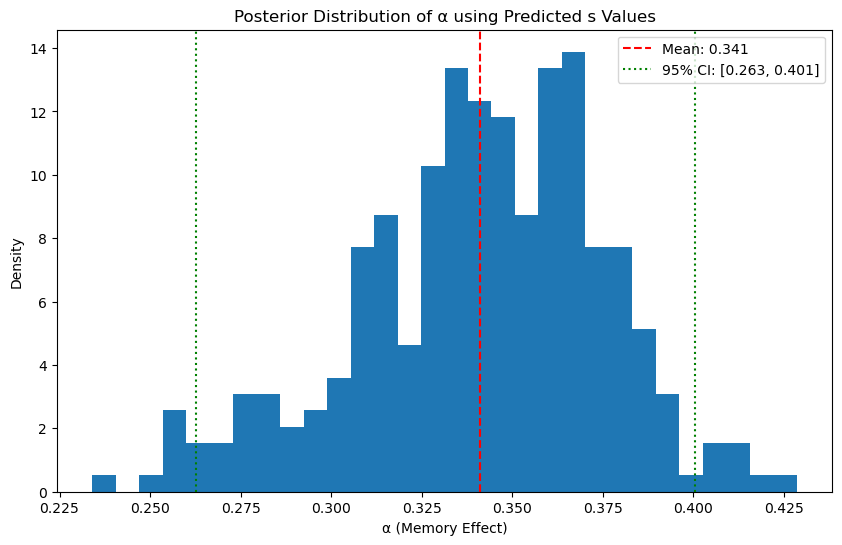

In [70]:
def predict_s_parallel(args):
   """
   Helper function for parallel s prediction
   """
   experiment, model = args
   with torch.no_grad():
       prediction = model(torch.FloatTensor(experiment).unsqueeze(0))
       return prediction[0, 1].item()

def predict_s_for_experiments(data, model, n_cores=None):
   """
   Predict s values for all experiments using the neural network in parallel
   """
   model.eval()
   
   # Create argument list
   args_list = [(experiment, model) for experiment in data]
   
   # Run parallel predictions
   with Pool(processes=n_cores) as pool:
       s_predictions = list(tqdm(
           pool.imap(predict_s_parallel, args_list),
           total=len(data),
           desc="Predicting s values"
       ))
   
   return s_predictions

def simulate_and_evaluate_fixed_s(args):
   """
   Helper function for parallel ABC with fixed s
   """
   experiment, s, h, iterations = args
   accepted_alphas = []
   observed_stats = calculate_summary_statistics(experiment)
   
   for _ in range(iterations):
       alpha_proposal = np.random.uniform(0, 0.5)
       
       simulated_data = simulate_multiple_beads(1000, alpha_proposal, s)
       simulated_stats = calculate_summary_statistics(simulated_data)
       
       mean_dist, std_dist = compute_distance(observed_stats, simulated_stats)
       kernel_value = gaussian_kernel(mean_dist, h) * gaussian_kernel(std_dist, h)
       
       if np.random.random() < kernel_value:
           accepted_alphas.append(alpha_proposal)
           
   return accepted_alphas

def abc_with_predicted_s(data, s_values, n_iterations=1000, h=0.1, n_cores=None):
   """
   Run ABC using the predicted s values for each experiment in parallel
   """
   iterations_per_experiment = max(1, n_iterations // len(data))
   total_iterations = iterations_per_experiment * len(data)
   
   print(f"Running {iterations_per_experiment} iterations per experiment")
   print(f"Total iterations: {total_iterations}")
   
   # Create argument list
   args_list = [(experiment, s, h, iterations_per_experiment) 
                for experiment, s in zip(data, s_values)]
   
   # Run parallel simulations
   with Pool(processes=n_cores) as pool:
       results = list(tqdm(
           pool.imap(simulate_and_evaluate_fixed_s, args_list),
           total=len(data),
           desc="Processing experiments"
       ))
   
   # Combine all accepted alphas
   all_accepted_alphas = [alpha for sublist in results for alpha in sublist]
   
   if len(all_accepted_alphas) > 0:
       print(f"\nTotal accepted samples: {len(all_accepted_alphas)}")
       print(f"Average acceptance rate: {len(all_accepted_alphas)/total_iterations:.1%}")
   else:
       print("\nNo samples were accepted. Try adjusting the kernel width (h)")
   
   return all_accepted_alphas

# Run the complete analysis
# First predict s for all experiments in parallel
s_predictions = predict_s_for_experiments(data, model)
print(f"Predicted s values range: [{min(s_predictions):.3f}, {max(s_predictions):.3f}]")

# Then run parallel ABC with these predictions
results = abc_with_predicted_s(data, s_predictions, n_iterations=10000)

if len(results) > 0:
   # Visualize results
   plt.figure(figsize=(10, 6))
   plt.hist(results, bins=30, density=True)
   plt.xlabel('α (Memory Effect)')
   plt.ylabel('Density')
   plt.title('Posterior Distribution of α using Predicted s Values')

   # Add statistical summary
   mean_alpha = np.mean(results)
   ci_low = np.percentile(results, 2.5)
   ci_high = np.percentile(results, 97.5)

   plt.axvline(mean_alpha, color='r', linestyle='--', label=f'Mean: {mean_alpha:.3f}')
   plt.axvline(ci_low, color='g', linestyle=':', 
               label=f'95% CI: [{ci_low:.3f}, {ci_high:.3f}]')
   plt.axvline(ci_high, color='g', linestyle=':')
   plt.legend()
   plt.show()
else:
   print("No results to plot")